In [1]:
import sys
import os


color_controlnet_dir = os.path.join("/home/pat", 'diffusion_augmentation', 'color_controlnet')
sys.path.append(color_controlnet_dir)

In [2]:
color_control_device = 'cuda:0'

In [3]:
# Color Control imports
from color_controlnet.diffusers import ControlNetModel, LineartDetector, StableDiffusionImg2ImgControlNetPalettePipeline
from color_controlnet.diffusers import UniPCMultistepScheduler
from color_controlnet.infer_palette import get_cond_color, show_anns, image_grid, HWC3, resize_in_buckets, SAMImageAnnotator
from color_controlnet.infer_palette_img2img import control_color_augment
from PIL import Image
import torch

/home/pat/miniconda3/envs/auto_aug2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
def initialize_models():
    """
    Initialize all models and detectors used in the pipeline
    Returns:
        control_net: dict, containing all ControlNet models and detectors
        llava: dict, containing the LLAVA model and processor
        zero123: dict, containing the Zero123 model and Carvekit interface
        color_control: dict, containing the Color Control model and SAM annotator

    """

    # Color Control model
    print('Loading Color Control model...')
    color_control = {}

    controlnet = ControlNetModel.from_config("./model_configs/controlnet_config.json").half()
    adapter = ControlNetModel.from_config("./model_configs/controlnet_config.json").half()

    sketch_method = "skmodel"
    sam_annotator = SAMImageAnnotator()

    model_ckpt = f"./models/color_img2img_palette.pt"
    model_sd = torch.load(model_ckpt, map_location="cpu")["module"]

    # assign the weights of the controlnet and adapter separately
    controlnet_sd = {}
    adapter_sd = {}
    for k in model_sd.keys():
        if k.startswith("controlnet"):
            controlnet_sd[k.replace("controlnet.", "")] = model_sd[k]
        if k.startswith("adapter"):
            adapter_sd[k.replace("adapter.", "")] = model_sd[k]

    msg_control = controlnet.load_state_dict(controlnet_sd, strict=True)
    print(f"msg_control: {msg_control} ")
    if adapter is not None:
        msg_adapter = adapter.load_state_dict(adapter_sd, strict=False)
        print(f"msg_adapter: {msg_adapter} ")

    # define the inference pipline
    # sdv15_path = "/home/pat/diffusion_augmentation/color_controlnet/model_configs/sd15_config.json"
    pipe = StableDiffusionImg2ImgControlNetPalettePipeline.from_pretrained(
        "runwayml/stable-diffusion-v1-5",
        controlnet=controlnet,
        adapter=adapter,
        torch_dtype=torch.float16,
        safety_checker=None,
    ).to(color_control_device)
    pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

    color_control['pipe'] = pipe
    color_control['sam_annotator'] = sam_annotator
    color_control['adapter'] = adapter 

    return color_control


In [5]:
color_control = initialize_models()


Loading Color Control model...


/home/pat/diffusion_augmentation/color_controlnet/diffusers/configuration_utils.py:195: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a model, please use <class 'color_controlnet.diffusers.models.controlnet.ControlNetModel'>.load_config(...) followed by <class 'color_controlnet.diffusers.models.controlnet.ControlNetModel'>.from_config(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  deprecate("config-passed-as-path", "1.0.0", deprecation_message, standard_warn=False)
/home/pat/diffusion_augmentation/color_controlnet/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/

msg_control: <All keys matched successfully> 
msg_adapter: <All keys matched successfully> 


Fetching 15 files: 100%|██████████| 15/15 [00:00<00:00, 160906.80it/s]
You have disabled the safety checker for <class 'color_controlnet.diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_img2img_controlnet_palette.StableDiffusionImg2ImgControlNetPalettePipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
The config attributes {'skip_prk_steps': True, 'set_alpha_to_one': False, 'steps_offset': 1, 'clip_sample': False} were passed to UniPCMultistepScheduler, but are not expected and will be ignored. Please verif

In [6]:
color_control

{'pipe': StableDiffusionImg2ImgControlNetPalettePipeline {
   "_class_name": "StableDiffusionImg2ImgControlNetPalettePipeline",
   "_diffusers_version": "0.15.0.dev0",
   "adapter": [
     "models",
     "ControlNetModel"
   ],
   "controlnet": [
     "models",
     "ControlNetModel"
   ],
   "feature_extractor": [
     "transformers",
     "CLIPImageProcessor"
   ],
   "requires_safety_checker": true,
   "safety_checker": [
     null,
     null
   ],
   "scheduler": [
     "diffusers",
     "PNDMScheduler"
   ],
   "text_encoder": [
     "transformers",
     "CLIPTextModel"
   ],
   "tokenizer": [
     "transformers",
     "CLIPTokenizer"
   ],
   "unet": [
     "diffusers",
     "UNet2DConditionModel"
   ],
   "vae": [
     "diffusers",
     "AutoencoderKL"
   ]
 },
 'sam_annotator': <color_controlnet.infer_palette.SAMImageAnnotator at 0x786c5d073ee0>,
 'adapter': ControlNetModel(
   (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (time_proj): Timestep

/home/pat/diffusion_augmentation/color_controlnet/diffusers/models/SKmodel.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(modelpath, 

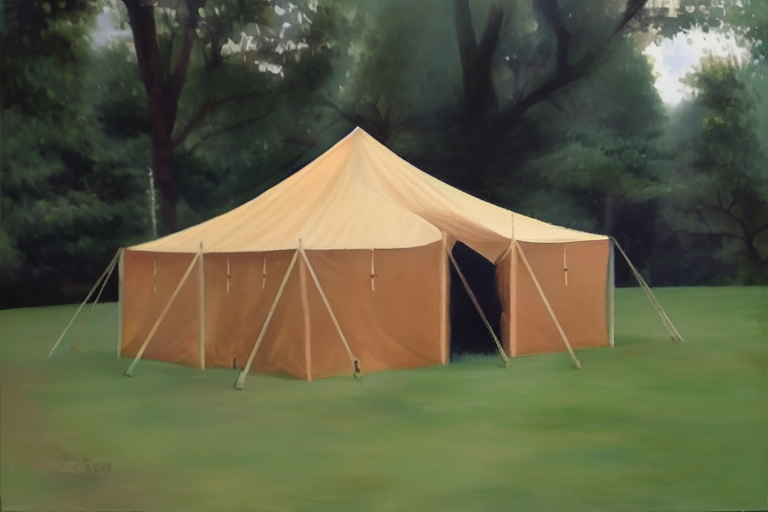

In [7]:
from IPython.display import display

example_image = Image.open("./test_images/original.png")
caption = "a painting of a tent with a forest in the background"

color_augmented = control_color_augment(example_image, color_control['adapter'], color_control['pipe'], caption, color_control['sam_annotator'], 1, color_control_device)

# color_augmented[0].save("./test_images/color_augmented.png")
# Display the image in the notebook

display(color_augmented[0])
# color_augmented[0].show()

In [8]:
#function for just random color augmentation with no controlnet

import colorsys
import numpy as np
def random_color_augmentation(image, num_colors=6):
        # Convert the image to grayscale
    grayscale = image.convert('L')
    
    # Convert grayscale image to numpy array
    gray_array = np.array(grayscale)
    
    # Generate random colors
    colors = [colorsys.hsv_to_rgb(np.random.random(), 
                                  np.random.uniform(0.5, 1.0), 
                                  np.random.uniform(0.5, 1.0)) for _ in range(num_colors)]
    
    # Create an empty array for the colored image
    colored_array = np.zeros((gray_array.shape[0], gray_array.shape[1], 3), dtype=np.float32)
    
    # Normalize the gray values to be between 0 and 1
    normalized_gray = gray_array / 255.0
    
    # Apply the color gradient
    for i in range(num_colors - 1):
        mask = ((normalized_gray >= i / (num_colors - 1)) & 
                (normalized_gray < (i + 1) / (num_colors - 1)))
        
        t = (normalized_gray[mask] - i / (num_colors - 1)) * (num_colors - 1)
        
        colored_array[mask] = (1 - t[:, np.newaxis]) * colors[i] + t[:, np.newaxis] * colors[i+1]
    
    # Handle the last interval
    mask = (normalized_gray >= (num_colors - 1) / (num_colors - 1))
    colored_array[mask] = colors[-1]
    
    # Convert to uint8
    colored_array = (colored_array * 255).astype(np.uint8)
    
    # Convert the numpy array back to a PIL Image
    colored_image = Image.fromarray(colored_array)
    
    return colored_image


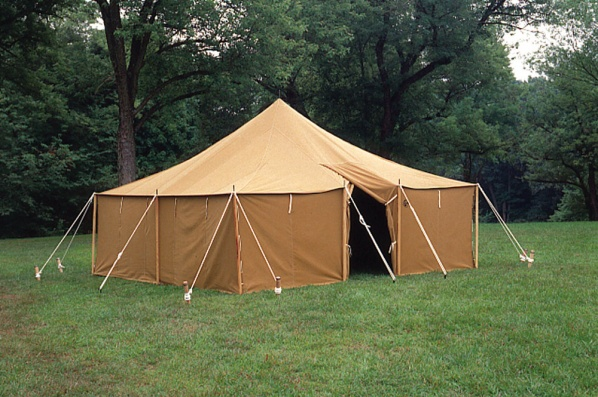

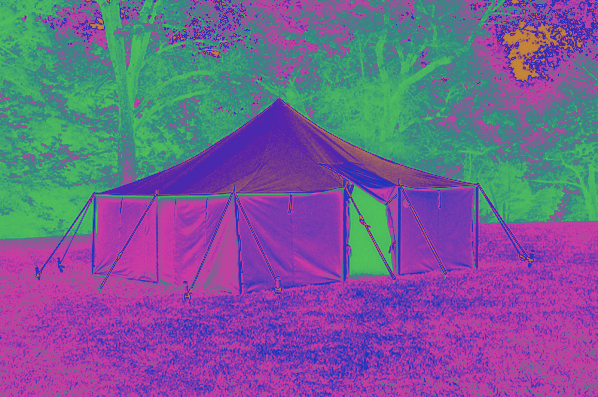

In [9]:
augmented_image = random_color_augmentation(example_image)
# display the original and augmented images
display(example_image)
display(augmented_image)